In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import importlib
import sys  
sys.path.insert(0, 'C:/Users/ed/Documents/Python_VSCode/ADIC2D/images')
import copy
import skimage as sk
import scipy as sp
import csv
import cv2 as cv
from scipy.linalg import solve

###import cv2 as cv
import numpy as np
import scipy as sp
import scipy.interpolate
#import Bicubic_interpolation
import math
import sys
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#general image for DIC analysis
class DICImage:
    def __init__(self,image,setup):
        self.image = image
        self.sub_size =  int(setup[0])
        self.SF_order = setup[1]
        self.GF_stddev = setup[2]
        self.GF_filtsize = int(setup[3])
        self.corr_refstrat = setup[4]
        self.frequency = int(setup[5])
        self.img_rows = setup[6]
        self.img_columns = setup[7]
        #create coordinates of pixels in subset relative to centre, dX dY
        #(constant subset size-these relative coordinates are the same for all subsets)
        #create coordinates for subset centers
        self.dX, self.dY, self.sub_centres, self.dx, self.dy = CreateSubsets(setup)
        #shape function parameters of F, 12 parameters for each subset
        self.P = np.zeros([6, self.sub_centres.shape[1]])      
#reference image F
class ReferenceImage(DICImage):
    def __init__(self,image,setup):
        super().__init__(image,setup)
        #gaussian filter applied to reference image
        #skip blur for now
        self.image = cv.GaussianBlur(image,(self.GF_filtsize,self.GF_filtsize),self.GF_stddev)
        #gradient of F in xy directions
        self.F_grad = np.array(np.gradient(self.image),dtype=float)
#deformed image G
class DeformedImage(DICImage):
    def __init__(self,image,setup):
        super().__init__(image,setup)
        self.image = cv.GaussianBlur(image,(self.GF_filtsize,self.GF_filtsize),self.GF_stddev)
        #interpolation of image at each pixel location, bicubic b-spline
        #interpolation of deformed image
        self.G_interp_coeff = scipy.interpolate.RegularGridInterpolator((np.linspace(0,self.image.shape[0]-1,self.image.shape[0]),np.linspace(0,self.image.shape[1]-1,self.image.shape[1])), self.image)
# create subset center positions
# #

    
def CreateSubsets(setup):
    sub_size = int(setup[0])
    sub_frequency = int(setup[5])
    img_rows = int(setup[6]) 
    img_columns = int(setup[7])
    #store subset centre coordinates as MESHGRIDS
    YOSX, XOSX = np.meshgrid(np.arange(int(0.5*(sub_size-1)+sub_frequency),int(img_rows-0.5*(sub_size-1)),sub_frequency),
                             np.arange(int(0.5*(sub_size-1)+sub_frequency),int(img_columns-0.5*(sub_size-1)),sub_frequency),
                             indexing = 'ij')
    #store subset centre coordinates as vectors
    XosX = XOSX.reshape([XOSX.shape[0]*XOSX.shape[1],1], order='F')
    YosX = YOSX.reshape([YOSX.shape[0]*YOSX.shape[1],1], order='F')
    sub_centers = np.vstack((XosX.T,YosX.T))
    #create subset relative coordinates
    [dY, dX]=np.meshgrid(np.linspace(-0.5*(sub_size-1),0.5*(sub_size-1),sub_size),
                        np.linspace(-0.5*(sub_size-1),0.5*(sub_size-1),sub_size),
                        indexing='ij')
    #save subsets relative coordinates as square matrices
    [dx, dy] = copy.deepcopy([dX,dY])
    #save subsets relative coordinates as column vectors
    dX = np.array(dX.reshape([np.size(dX),1], order = 'F'))
    dY = np.array(dY.reshape([np.size(dY),1], order = 'F'))
    return dX, dY, sub_centers, dx, dy
#define reference subset and its gradients based on center position
# #
#initial estimate for correlation as rigid body translation
def CorrEst0():

    return 0,0
def RefSubsetInfo(F,i):
    #inherited from F (is this ordering right?)
    F_grady, F_gradx = [F.F_grad[0]/6, F.F_grad[1]/6]
    #xy coordinates of i'th subset centre
    centerx, centery = np.array([F.sub_centres[0][i],F.sub_centres[1][i]])
    #extract  subset information
    f = F.image[centery-int(0.5*(F.sub_size-1)):centery+int(0.5*(F.sub_size-1))+1,
                centerx-int(0.5*(F.sub_size-1)):centerx+int(0.5*(F.sub_size-1))+1]
    #extract subset spatial gradients
    dfdy = F_grady[centery-int(0.5*(F.sub_size-1)):centery+int(0.5*(F.sub_size-1))+1,
                    centerx-int(0.5*(F.sub_size-1)):centerx+int(0.5*(F.sub_size-1))+1]
    dfdx = F_gradx[centery-int(0.5*(F.sub_size-1)):centery+int(0.5*(F.sub_size-1))+1,
                    centerx-int(0.5*(F.sub_size-1)):centerx+int(0.5*(F.sub_size-1))+1]
    #average subset intensity, and sum of squared differences
    f_mean = f.mean()
    f_tilde = np.sqrt(np.sum((f[:]-f_mean)**2))
    return f, f_mean, f_tilde, dfdx, dfdy
#Hessian, used for first order taylor series ezpansion of the objective function
# #
def Hessian(dfdx,dfdy,F):
    #store intensity gradients of subset as vectors
    fx = dfdx.reshape([dfdx.shape[0]**2,1], order='F')
    fy = dfdy.reshape([dfdy.shape[0]**2,1], order='F')
    #assign subset coordinates
    x = F.dX
    y = F.dY
    #procuct of f subset gradient and 
    fgrad_X_dWdP = np.zeros([fx.shape[0], 6])
    for l in range(0,fx.shape[0]):
        fgrad_X_dWdP[l,:] = np.array([[fx[l,0]], [fx[l,0]*x[l,0]], [fx[l,0]*y[l,0]],[fy[l,0]], [fy[l,0]*x[l,0]], [fy[l,0]*y[l,0]]]).T
    Hess = np.sum(fgrad_X_dWdP[:]*fgrad_X_dWdP[:])

    return Hess, fgrad_X_dWdP
#rigid body translation
# #
def RigidBodyTrans():
    #subset deformation parameters/SFP's
    u, v = [G.P[0,i], G.P[1,i]]
    #assign subset coordinates
    x = G.dX
    y = G.dY
    #displace subset in xy-coordinates (14):
    #order of SFP's P[i]: 0,  1
    #                     u   v
    Wx = x + u
    Wy = y + v
    #rigid body translation
    W = np.hstack([Wx, Wy])
    return W
#Affine transformation warp function
# #
def AffineTrans(G,i):
    #subset deformation parameters/SFP's
    P = G.P[:,i]
    #assign subset coordinates
    x = G.dX
    y = G.dY
    #displace, stretch and shear subset in xy-coordinates (14):
    #order of SFP's P[i]: 0,  1,  2,  3,  4,  5
    #                     u   ux  uy  v   vx  vy
    Wx = (1+P[1])*x + P[2]*y + P[0]
    Wy = P[4]*x + (1+P[5])*y + P[3]
    #warp function/shape function/affine transformation in this case
    W = np.hstack([Wx, Wy])
    return W
#define deformed subset based on center position
# #
def DefSubsetInfo(G, defXY,i):
    #deform subset to obtain new intensity values(G_interp_coeff is a function of the xy coordinates)
    y = G.sub_centres[1,i]*np.ones(defXY.shape[0]) + defXY[:,1]
    x = G.sub_centres[0,i]*np.ones(defXY.shape[0]) + defXY[:,0]
    g = np.zeros(y.shape[0])
    for m in range(0,y.shape[0]):
        g[m] = G.G_interp_coeff(np.array([y[m],x[m]]))
    g_mean = g.mean()
    g_tilde = np.sqrt(np.sum((g[:]-g_mean)**2))
    return g, g_mean, g_tilde
#update SFP's for next iteration of subset correlation
# #
def UpdateSFP(P, deltaP):
    #(22)
    #w of current estimate of SFPs
    #order of SFP's P[i]: 0,  1,  2,  3,  4,  5
    #                     u   ux  uy  v   vx  vy
    wP = np.array([[1+P[1], P[2], P[0]],
                    [P[4], 1+P[5], P[3]],
                    [0,      0,      1]])
    #w of current deltaP               
    wdP = np.array([[1+deltaP[1,0], deltaP[2,0], deltaP[0,0]],
                    [deltaP[4,0], 1+deltaP[5,0], deltaP[3,0]],
                    [0,      0,      1]])
    up = wP*np.linalg.inv(wdP)
    #(21)
    Pupdate = np.array([[up[0,2]],[1-up[0,0]],[up[0,1]],[up[1,2]],[up[1,0]],[1-up[1,1]]])
    return Pupdate
#convergence criteria for subset correlation (is this actually correct ?)
# #
def StopCriteria(dP, zeta):
    # (23)
    b = np.array([[1,zeta,zeta,1,zeta,zeta]])
    ConCrit = np.sqrt(np.sum((dP*b)**2))
    return ConCrit

image shape: (501, 2000)
Reference image:


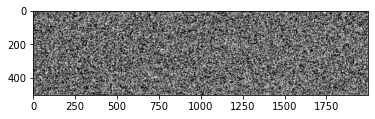

In [228]:
#import intensity images from csv files
img_1 = cv.imread('star1_ref.tif',0)
img_2 = cv.imread('star1_def.tif',0)
print('image shape:', img_1.shape)

print('Reference image:')
plt.imshow(img_1, cmap = 'gray')
plt.show()

In [229]:
#define setup parameters
img_rows = img_1.shape[0]
img_columns = img_1.shape[1]
setup = np.array([int(41),1,0.5,int(5),0,int(5)])
setup = np.append(setup,img_rows)
setup = np.append(setup,img_columns)
sub_size = int(setup[0])
SF_order = setup[1]
GF_stddev = setup[2]
GF_filtsize = int(setup[3])
corr_refstrat = setup[4]
sub_frequency = int(setup[5])
print(setup)
N_images = 2

[4.10e+01 1.00e+00 5.00e-01 5.00e+00 0.00e+00 5.00e+00 5.01e+02 2.00e+03]


In [231]:
for n_image in range(2,N_images+1):
    #assign G, deformed image
    exec(f'G = img_{n_image}')
    G = DeformedImage(G,setup)
    #if incremental strategy or if analysing first deformed image
    if corr_refstrat==1 or n_image==2:
        #assign F, reference image
        exec(f'F = img_{n_image-1}')
        F = ReferenceImage(F,setup)
        G.sub_centres[0,:] = F.sub_centres[0,:] + np.round(F.P[0,:])
        G.sub_centres[1,:] = F.sub_centres[1,:] + np.round(F.P[3,:])
        #initial estimate of SFPs for G
        G.P[0,:], G.P[3,:] = np.array([15,0])
        #absolute reference strategy
    else:
        #this line we should actually replace the previous correlation run between F and G's
        #SFP's at convergence as the initial estimate for the shape function parameters of G
        G.P[0,:], G.P[3,:] = F.P[0,:], F.P[3,:]
    #convergence info   
    N_subsets = F.sub_centres.shape[1]
    P = np.zeros([6, N_subsets]) 
    corr_crit = np.zeros([1, N_subsets])
    iterations = np.array([1, N_subsets])
    stop_val = np.array([1, N_subsets])
    #perform correlation for each subset, specified by index i
    for i in range(0,N_subsets):
        #extract subset from F
        f, f_mean, f_tilde, dfdx, dfdy  = RefSubsetInfo(F,i)
        #returns Hessian and product of f_grad and dWdP
        Hess, fgrad_X_dWdP = Hessian(dfdx, dfdy, F)
        #initial deltaP vector
        dP =  np.ones([6,1])
        itera = 0
        while itera < 100:
            #deform square subset with linear transformation based on current estimation of warp function parameters (u   ux  uy  v   vx  vy)
            defXY = AffineTrans(G,i)
            #extract subset from interpolated G
            g, g_mean, g_tilde = DefSubsetInfo(G, defXY, i)
            stop_val = StopCriteria(dP, 0.5*(G.sub_size-1))


KeyboardInterrupt: 

In [ ]:
YOSX, XOSX = np.meshgrid(np.arange(int(0.5*(sub_size-1)+sub_frequency),int(img_rows-0.5*(sub_size-1)),sub_frequency),
                             np.arange(int(0.5*(sub_size-1)+sub_frequency),int(img_columns-0.5*(sub_size-1)),sub_frequency),
                             indexing = 'ij')
print(G.image.shape)  
print(F.sub_centres)    
print(G.P.shape)     
sub_centers = F.sub_centres      
print(F.dX.shape)        

(501, 2000)
[[  25   25   25 ... 1975 1975 1975]
 [  25   30   35 ...  470  475  480]]
(6, 35972)
(1681, 1)


In [ ]:
centerx, centery = np.array([F.sub_centres[0][5],F.sub_centres[1][5]])
F_grady, F_gradx = [F.F_grad[0]/6, F.F_grad[1]/6]
dfdy = F_grady[centery-int(0.5*(F.sub_size-1)):centery+int(0.5*(F.sub_size-1))+1,
                    centerx-int(0.5*(F.sub_size-1)):centerx+int(0.5*(F.sub_size-1))+1]
dfdx = F_gradx[centery-int(0.5*(F.sub_size-1)):centery+int(0.5*(F.sub_size-1))+1,
                    centerx-int(0.5*(F.sub_size-1)):centerx+int(0.5*(F.sub_size-1))+1]

In [ ]:
print(F.dx.shape,'\n',F.dX.shape)

(41, 41) 
 (1681, 1)


In [ ]:
#subset intensity value storing scheme
testmat = np.array([[1,2,3],[4,5,6],[7,8,9]])
testvec = testmat.reshape([testmat.shape[0]**2,1], order='F')
print(testmat,'\n',testvec)

[[1 2 3]
 [4 5 6]
 [7 8 9]] 
 [[1]
 [4]
 [7]
 [2]
 [5]
 [8]
 [3]
 [6]
 [9]]


In [ ]:
print(defXY.shape)

(1681, 2)


In [ ]:
A = cv.imread('star1_def.tif',0)
gridy, gridx = np.mgrid[:A.shape[0], :A.shape[1]]

i = np.linspace(0,A.shape[0]-1,A.shape[0])
j = np.linspace(0,A.shape[1]-1,A.shape[1])
print(j.shape, i.shape)
AA = scipy.interpolate.RegularGridInterpolator((np.linspace(0,A.shape[0]-1,A.shape[0]),np.linspace(0,A.shape[1]-1,A.shape[1])), A)
print(A[0,0])
#call intensity at non-pixel locations
print(AA(np.array([0.1,0])))

(2000,) (501,)
163
[162.2]


In [ ]:
y = G.sub_centres[1,i]*np.ones(defXY.shape[0]) + defXY[:,1]
x = G.sub_centres[0,i]*np.ones(defXY.shape[0]) + defXY[:,0]
g = np.zeros(y.shape[0])
for m in range(0,y.shape[0]):
    g[m] = G.G_interp_coeff(np.array([y[m],x[m]]))


In [ ]:
[dY, dX]=np.meshgrid(np.linspace(-0.5*(sub_size-1),0.5*(sub_size-1),sub_size),
                        np.linspace(-0.5*(sub_size-1),0.5*(sub_size-1),sub_size),
                        indexing='ij')
    #save subsets as square matrices
[dx, dy] = copy.deepcopy([dX,dY])
    #save subsets as column vectors
dX = np.array(dX.reshape([np.size(dX),1], order = 'F'))
dY = np.array(dY.reshape([np.size(dY),1], order = 'F'))

print(dX)
print(dY)

[[-20.]
 [-20.]
 [-20.]
 ...
 [ 20.]
 [ 20.]
 [ 20.]]
[[-20.]
 [-19.]
 [-18.]
 ...
 [ 18.]
 [ 19.]
 [ 20.]]
